# The purpose of this project is to detect objects in images using Convolutional Neural Network

## tool used for data visualization : matplotlib

## tool used for data preprocessing: a custom made function create_inhouse_dataset was used to set the number of images and the image size for the model. The bounding boxes to localize data was also created using this function

## model used for prediction: Convolutional Neural Network

## tools used for data validation: IOU (Calculate overlap between two bounding boxes  as the area of intersection over the area of unity)
 



In [ ]:
import os
from google.colab import drive 
drive.mount('/content/drive')

work_dir = '/content/drive/My Drive/Colab Notebooks/Object Detection Homework'
os.makedirs(work_dir, exist_ok=True)
os.chdir(work_dir)
%pwd 
%ls

Mounted at /content/drive
 checkmodel.h5               imgs_backup_10000.npy
'Copy of homework07.ipynb'   imgs_backup_50000.npy
 dataset_object/             imgs_box_backup_10000.npy
 dataset_object.zip          imgs_box_backup_50000.npy
 homework07.ipynb            object_detection_my_data_10000_model.h5


In [ ]:
# Data Collection

In [ ]:
!rm -rf dataset_object
!rm -rf dataset_object*zip
#!wget https://cs.slu.edu/~hou/5750/data/object_detection/dataset_object.zip --no-check-certificate
!wget https://cs.slu.edu/~hou/5750/homework/hw07/dataset_object.zip --no-check-certificate
!unzip  dataset_object.zip

--2020-11-04 00:34:10--  https://cs.slu.edu/~hou/5750/homework/hw07/dataset_object.zip
Resolving cs.slu.edu (cs.slu.edu)... 165.134.107.79
Connecting to cs.slu.edu (cs.slu.edu)|165.134.107.79|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 103318 (101K) [application/zip]
Saving to: ‘dataset_object.zip’

dataset_object.zip  100%[===================>] 100.90K  --.-KB/s    in 0.1s    

2020-11-04 00:34:11 (814 KB/s) - ‘dataset_object.zip’ saved [103318/103318]

Archive:  dataset_object.zip
   creating: dataset_object/
  inflating: dataset_object/StopSign_1.jpg  
  inflating: dataset_object/car_1.jpg  
   creating: dataset_object/test_data/
  inflating: dataset_object/test_data/test_1.xml  
  inflating: dataset_object/test_data/test_6.jpg  
  inflating: dataset_object/test_data/test_5.jpg  
  inflating: dataset_object/test_data/test_4.jpg  
  inflating: dataset_object/test_data/test_3.jpg  
  inflating: dataset_ob

In [ ]:
%ls dataset_object/

car_1.jpg  StopSign_1.jpg  test_data/


In [ ]:
# Data Visualization

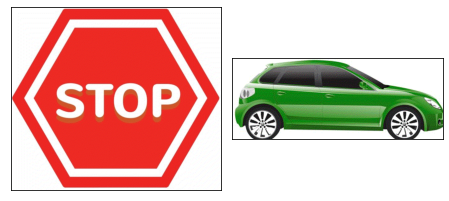

In [ ]:
from matplotlib import pyplot as plt
import glob

import base64
from PIL import Image
import numpy as np

fig = plt.figure(figsize=(6, 6)) # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

## plot first image
img_path ='dataset_object/StopSign_1.jpg'
ax = fig.add_subplot(1,2,1, xticks=[], yticks=[])
# PIL image, convert to mode "P" to translates pixels through the palette and range of pixels still in [0,255] with color image 
img = Image.open(img_path).convert("P") 
ax.imshow(img)
img.close()

## plot second image
img_path ='dataset_object/car_1.jpg'
ax = fig.add_subplot(1,2,2, xticks=[], yticks=[])
img = Image.open(img_path).convert("P") 
ax.imshow(img)
img.close()

In [ ]:
# Data Preprocessing and build in-house Dataset

In [ ]:
import numpy as np
import random

def create_inhouse_dataset(num_imgs, img_size = 128):
    ### num_imgs: number of images to create (Note: increase this number may improve performance)
    ### img_size: set image size to 128*128 (Note: can also practice different size)


    ### size of bounding box for object
    stop_size_min = 30
    stop_size_max = 50

    ### number of interested object, here we set 1 for simplicity
    num_objects = 1

    ### create arrays to store images (X)
    imgs = np.empty((num_imgs, img_size, img_size))  # set image background to 255 (white)
    imgs.fill(255)

    ### create arrays to store boundary boxes (Y)
    bboxes = np.zeros((num_imgs, num_objects, 4))

    ### Start create custom images
    for i_img in range(num_imgs):
        
        boxes_cur = [] # check overlap
        for i_object in range(num_objects):
          
          ### sample the width and height for object
          width, height = np.random.randint(stop_size_min, stop_size_max, size=2)
          
          ### sample location to put object in image
          row = np.random.randint(0, img_size - height)
          column = np.random.randint(0, img_size - width)


          img_path ='dataset_object/StopSign_1.jpg'
          img = Image.open(img_path) # RGB mode with three channel
          # PIL image, convert to mode "P" to translates pixels through the palette and range of pixels still in [0,255] with color image 
          img = img.convert("P")  # convert into one channel
          img = img.resize((width, height)) # resize

          # convert into numpy array
          img_data = np.asarray(img).copy()
          img_data[img_data>=np.quantile(img_data, .6)] = 255 # set background to white
          imgs[i_img, row:row+height, column:column+width] = np.asarray(img_data)  # set local region to this object
          bboxes[i_img, i_object] = [column, row, width, height]
          boxes_cur.append([column, row, width, height]) # store the region that has been embedded.
        

        ### number of non-interested objects (car) to be added
        num_car = np.random.randint(3, 10)
        width,height= 40,20
        for pos in range(0, int(img_size/width)*int(img_size/height)):
              row = int(pos/int(img_size/width))*height
              column = int(pos % int(img_size/width))*width
              ### check if overlaping with any objects
              check_valid = True
              for bbox in boxes_cur:
                  x1, y1, w1, h1 = bbox[0], bbox[1], bbox[2], bbox[3]
                  x2, y2, w2, h2 = column, row, width, height
                  w_I = min(x1 + w1, x2 + w2) - max(x1, x2)
                  h_I = min(y1 + h1, y2 + h2) - max(y1, y2)
                  if w_I > 0 or h_I > 0:  #  overlap
                      check_valid = False
                      break
              if check_valid:
                boxes_cur.append([column, row, width, height])
                img_path ='dataset_object/car_1.jpg'
                img = Image.open(img_path).convert("P") 
                img = img.resize((width, height))
                img_data = np.asarray(img).copy()
                img_data[img_data>np.quantile(img_data, .6)] = 255 # set background to white
                imgs[i_img, row:row+height, column:column+width] = np.asarray(img_data)  # set local region to this object
                if len(boxes_cur)-1<num_car:
                  continue
                else:
                  break
    return imgs, bboxes

In [ ]:
# set to 100 for demo, but high accuracy can be achievied with number set to 50000
num_imgs = 10000

### set image size to 128*128 (Note: can also practice different size)
img_size = 128 

imgs, bboxes = create_inhouse_dataset(num_imgs, img_size = 128) # may take time if num_imgs is set too large

imgs.shape, bboxes.shape

((10000, 128, 128), (10000, 1, 4))

In [ ]:
# save the train data for later use.
save_data = True
if save_data:
  import numpy as np
  np.save('imgs_backup_10000', imgs) 
  np.save('imgs_box_backup_10000', bboxes) 

In [ ]:
# Visualize the data

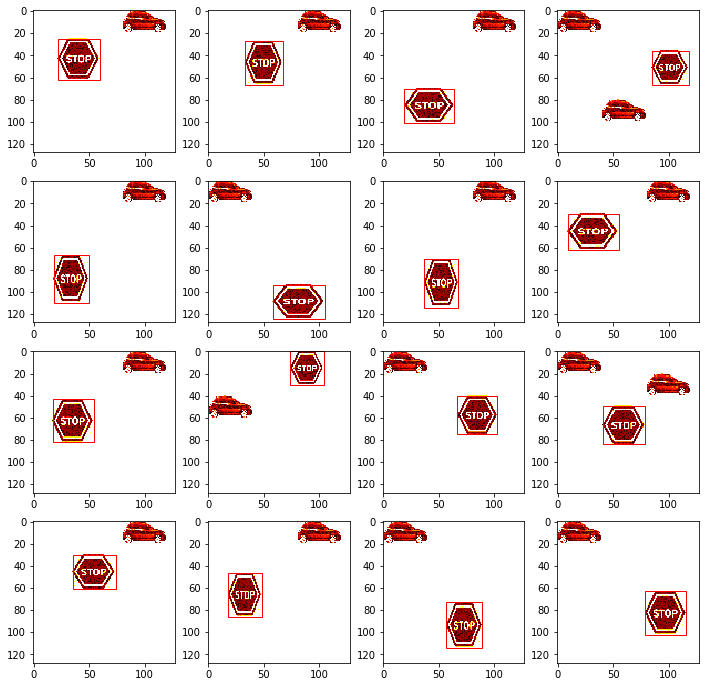

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

plt.figure(figsize=(12, 12))
for img_idx in range(1,17):
    plt.subplot(4, 4, img_idx)
    img = Image.fromarray(imgs[img_idx])
    plt.imshow(imgs[img_idx], cmap='hot', interpolation='nearest')
    for bbox in bboxes[img_idx]:
        plt.gca().add_patch(matplotlib.patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], ec='r', fc='none'))

In [ ]:
X = (imgs - np.mean(imgs)) / np.std(imgs)

# save the mean and std
train_mean = np.mean(imgs)
train_std = np.std(imgs)
print(X)

[[[0.30838494 0.30838494 0.30838494 ... 0.30838494 0.30838494 0.30838494]
  [0.30838494 0.30838494 0.30838494 ... 0.30838494 0.30838494 0.30838494]
  [0.30838494 0.30838494 0.30838494 ... 0.30838494 0.30838494 0.30838494]
  ...
  [0.30838494 0.30838494 0.30838494 ... 0.30838494 0.30838494 0.30838494]
  [0.30838494 0.30838494 0.30838494 ... 0.30838494 0.30838494 0.30838494]
  [0.30838494 0.30838494 0.30838494 ... 0.30838494 0.30838494 0.30838494]]

 [[0.30838494 0.30838494 0.30838494 ... 0.30838494 0.30838494 0.30838494]
  [0.30838494 0.30838494 0.30838494 ... 0.30838494 0.30838494 0.30838494]
  [0.30838494 0.30838494 0.30838494 ... 0.30838494 0.30838494 0.30838494]
  ...
  [0.30838494 0.30838494 0.30838494 ... 0.30838494 0.30838494 0.30838494]
  [0.30838494 0.30838494 0.30838494 ... 0.30838494 0.30838494 0.30838494]
  [0.30838494 0.30838494 0.30838494 ... 0.30838494 0.30838494 0.30838494]]

 [[0.30838494 0.30838494 0.30838494 ... 0.30838494 0.30838494 0.30838494]
  [0.30838494 0.308384

In [ ]:
y = bboxes.reshape(num_imgs, -1) / img_size

y.shape, np.mean(y), np.std(y)

print(y)

[[0.3359375 0.2421875 0.28125   0.2578125]
 [0.171875  0.1953125 0.296875  0.2890625]
 [0.2578125 0.2109375 0.265625  0.3125   ]
 ...
 [0.046875  0.328125  0.3046875 0.359375 ]
 [0.3984375 0.1875    0.3203125 0.3671875]
 [0.1484375 0.25      0.359375  0.3828125]]


In [ ]:
from sklearn.model_selection import ShuffleSplit
split = ShuffleSplit(n_splits=1, test_size=.2, random_state=0)
for train_index, test_index in split.split(X):
    #print("TRAIN:", train_index, "\nTEST:", test_index)
    train_X = X[train_index]
    test_X = X[test_index]
    train_y = y[train_index]
    test_y = y[test_index]
    test_imgs = imgs[test_index]
    test_bboxes = bboxes[test_index]

In [ ]:
print(train_X.shape)
print(train_y.shape)
print(test_X.shape)
print(test_y.shape)

(8000, 128, 128)
(8000, 4)
(2000, 128, 128)
(2000, 4)


In [ ]:
im_rows = 128
im_cols = 128
im_shape = (im_rows, im_cols, 1)

x_train = train_X.reshape(train_X.shape[0], *im_shape)
x_test = test_X.reshape(test_X.shape[0], *im_shape)

In [ ]:
print(x_train.shape)
print(train_y.shape)
print(x_test.shape)
print(test_y.shape)

(8000, 128, 128, 1)
(8000, 4)
(2000, 128, 128, 1)
(2000, 4)


In [ ]:
print(x_train)

[[[[0.30838494]
   [0.30838494]
   [0.30838494]
   ...
   [0.30838494]
   [0.30838494]
   [0.30838494]]

  [[0.30838494]
   [0.30838494]
   [0.30838494]
   ...
   [0.30838494]
   [0.30838494]
   [0.30838494]]

  [[0.30838494]
   [0.30838494]
   [0.30838494]
   ...
   [0.30838494]
   [0.30838494]
   [0.30838494]]

  ...

  [[0.30838494]
   [0.30838494]
   [0.30838494]
   ...
   [0.30838494]
   [0.30838494]
   [0.30838494]]

  [[0.30838494]
   [0.30838494]
   [0.30838494]
   ...
   [0.30838494]
   [0.30838494]
   [0.30838494]]

  [[0.30838494]
   [0.30838494]
   [0.30838494]
   ...
   [0.30838494]
   [0.30838494]
   [0.30838494]]]


 [[[0.30838494]
   [0.30838494]
   [0.30838494]
   ...
   [0.30838494]
   [0.30838494]
   [0.30838494]]

  [[0.30838494]
   [0.30838494]
   [0.30838494]
   ...
   [0.30838494]
   [0.30838494]
   [0.30838494]]

  [[0.30838494]
   [0.30838494]
   [0.30838494]
   ...
   [0.30838494]
   [0.30838494]
   [0.30838494]]

  ...

  [[0.30838494]
   [0.30838494]
   [0.3

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D,MaxPooling2D
from keras import regularizers
from keras.layers import Flatten,BatchNormalization,Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
keras_callbacks   = [
      EarlyStopping(monitor='val_loss', patience=10, mode='min', min_delta=0.0001),
      ModelCheckpoint('./checkmodel.h5', monitor='val_loss', save_best_only=True, mode='min')
]


model = Sequential() # create Sequential model
model.add(Conv2D(9, (3,3), input_shape=(128,128,1), padding='same', activation = 'relu')) 
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
#model.add(Dropout(0.2))

model.add(Conv2D(9, (3,3), padding='same',activation = 'relu')) 
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
#model.add(Dropout(0.2))

model.add(Conv2D(9, (3,3), padding='same',activation = 'relu')) 
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
#model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(4, activation = 'sigmoid')) 
model.compile(loss = "mean_squared_error", optimizer = "adam", metrics = ['mse'])

model.summary()
#history = model.fit(X_train_s,y_train_s, validation_data=(X_val,y_val), batch_size=64, epochs = 20)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 128, 128, 9)       90        
_________________________________________________________________
batch_normalization_27 (Batc (None, 128, 128, 9)       36        
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 64, 64, 9)         0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 64, 64, 9)         738       
_________________________________________________________________
batch_normalization_28 (Batc (None, 64, 64, 9)         36        
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 32, 32, 9)         0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 32, 32, 9)        

In [ ]:
train_history = model.fit(x_train,train_y, validation_split=0.1, batch_size = 25, epochs = 50, callbacks=keras_callbacks)

Epoch 1/50
288/288 [==============================] - 85s 294ms/step - loss: 0.0024 - mse: 0.0024 - val_loss: 0.0025 - val_mse: 0.0025
Epoch 2/50
288/288 [==============================] - 85s 295ms/step - loss: 0.0012 - mse: 0.0012 - val_loss: 0.0015 - val_mse: 0.0015
Epoch 3/50
288/288 [==============================] - 84s 292ms/step - loss: 8.8926e-04 - mse: 8.8926e-04 - val_loss: 9.6233e-04 - val_mse: 9.6233e-04
Epoch 4/50
288/288 [==============================] - 84s 292ms/step - loss: 7.4316e-04 - mse: 7.4316e-04 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 5/50
288/288 [==============================] - 84s 292ms/step - loss: 6.8058e-04 - mse: 6.8058e-04 - val_loss: 6.8416e-04 - val_mse: 6.8416e-04
Epoch 6/50
288/288 [==============================] - 84s 291ms/step - loss: 5.8855e-04 - mse: 5.8855e-04 - val_loss: 4.5613e-04 - val_mse: 4.5613e-04
Epoch 7/50
288/288 [==============================] - 84s 292ms/step - loss: 5.4417e-04 - mse: 5.4417e-04 - val_loss: 4.5492e-04 - val

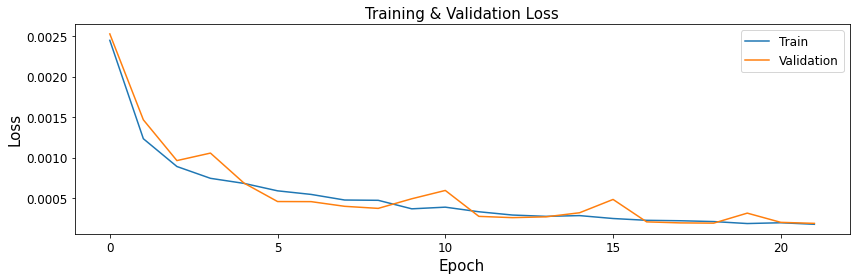

In [ ]:
plt.figure(figsize=(12,4))

plt.subplot(1,1,1)
# Plot training & validation loss values
plt.plot(train_history.history['loss'], label='Train')
plt.plot(train_history.history['val_loss'], label='Validation')
plt.title('Training & Validation Loss', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.xlabel('Epoch', fontsize=15)
plt.xticks( fontsize=12)
plt.yticks( fontsize=12)
plt.legend(loc='upper right', fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
### Define the calculation of IoU score
def IOU(bbox1, bbox2):
    '''Calculate overlap between two bounding boxes [x, y, w, h] as the area of intersection over the area of unity'''
    x1, y1, w1, h1 = bbox1[0], bbox1[1], bbox1[2], bbox1[3]
    x2, y2, w2, h2 = bbox2[0], bbox2[1], bbox2[2], bbox2[3]

    w_I = min(x1 + w1, x2 + w2) - max(x1, x2)
    h_I = min(y1 + h1, y2 + h2) - max(y1, y2)
    if w_I <= 0 or h_I <= 0:  # no overlap
        return 0.
    I = w_I * h_I

    U = w1 * h1 + w2 * h2 - I

    return I / U

In [ ]:
pred_y = model.predict(x_test)
pred_bboxes = pred_y * img_size
pred_bboxes = pred_bboxes.reshape(len(pred_bboxes), 1, -1)
pred_bboxes.shape

(2000, 1, 4)

In [ ]:
x_test.shape

(2000, 128, 128, 1)

In [ ]:
# Predict bounding boxes on the test images.
pred_y = model.predict(x_test)
pred_bboxes = pred_y * img_size
pred_bboxes = pred_bboxes.reshape(len(pred_bboxes), 1, -1)
pred_bboxes.shape

summed_IOU = 0.
for pred_bbox, test_bbox in zip(pred_bboxes.reshape(-1, 4), test_bboxes.reshape(-1, 4)):
    summed_IOU += IOU(pred_bbox, test_bbox)
mean_IOU = summed_IOU / len(pred_bboxes)
print("Testing IOU: ",mean_IOU)

Testing IOU:  0.8683068499096251


In [ ]:
from keras.models import load_model

# save the model to disk
model.save("object_detection_my_data_10000_model.h5")

# load the model from disk
model_loaded = load_model("object_detection_my_data_10000_model.h5")

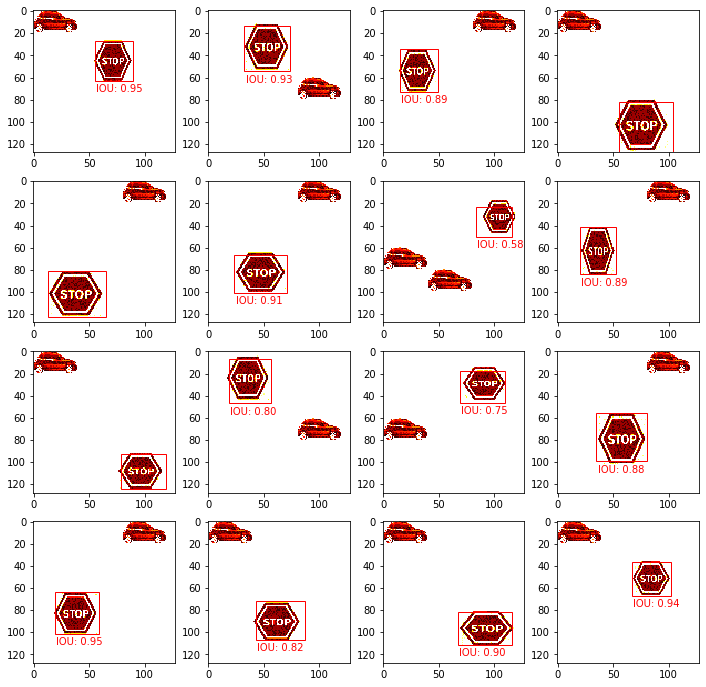

In [ ]:
plt.figure(figsize=(12, 12))
for i_subplot in range(1, 17):
    plt.subplot(4, 4, i_subplot)
    i = np.random.randint(len(test_imgs))
    plt.imshow(test_imgs[i], cmap='hot', interpolation='nearest')
    
    for pred_bbox, exp_bbox in zip(pred_bboxes[i], test_bboxes[i]):
        plt.gca().add_patch(matplotlib.patches.Rectangle((pred_bbox[0], pred_bbox[1]), pred_bbox[2], pred_bbox[3], ec='r', fc='none'))
        plt.annotate('IOU: {:.2f}'.format(IOU(pred_bbox, exp_bbox)), (pred_bbox[0]+1, pred_bbox[1]+pred_bbox[3]+10), color='r')

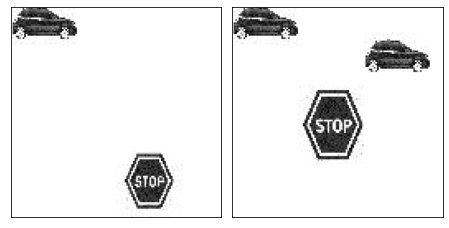

In [ ]:
from matplotlib import pyplot as plt
import glob

import base64
from PIL import Image
import numpy as np

fig = plt.figure(figsize=(6, 6)) # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

## plot first image
img_path ='dataset_object/test_data/test_1.jpg'
ax = fig.add_subplot(1,2,1, xticks=[], yticks=[])
# PIL image, convert to mode "P" to translates pixels through the palette and range of pixels still in [0,255] with color image 
img = Image.open(img_path).convert("P") 
ax.imshow(img)
img.close()

## plot second image
img_path ='dataset_object/test_data/test_2.jpg'
ax = fig.add_subplot(1,2,2, xticks=[], yticks=[])
img = Image.open(img_path).convert("P") 
ax.imshow(img)
img.close()

In [ ]:
### Here we define a function to extract information from VOC XML format file.
import xml.etree.ElementTree as ET
def read_content(xml_file: str):

    tree = ET.parse(xml_file)
    root = tree.getroot()

    list_with_all_boxes = []

    for boxes in root.iter('object'):

        filename = root.find('filename').text

        ymin, xmin, ymax, xmax = None, None, None, None

        for box in boxes.findall("bndbox"):
            ymin = int(box.find("ymin").text)
            xmin = int(box.find("xmin").text)
            ymax = int(box.find("ymax").text)
            xmax = int(box.find("xmax").text)

        list_with_single_boxes = [xmin, ymin, xmax, ymax]
        list_with_all_boxes.append(list_with_single_boxes)

    return filename, list_with_all_boxes

In [ ]:
# Showing all the labelled images in unseen dataset manually using labellmg both the StopSign and the Car

In [ ]:
dataset_workdir = "/content/drive/My Drive/Colab Notebooks/Object Detection Homework/dataset_object/test_data"
files = ['test_1.xml','test_2.xml','test_3.xml','test_4.xml','test_5.xml','test_6.xml']
for file in files:
  name, boxes = read_content(dataset_workdir+'/'+ file)
  print(name)
  print(boxes)


test_1.jpg
[[62, 85, 106, 127], [1, 1, 47, 24]]
test_2.jpg
[[38, 48, 87, 97], [1, 1, 44, 24]]
test_3.jpg
[[81, 18, 121, 65], [1, 1, 45, 23], [37, 76, 85, 107]]
test_4.jpg
[[4, 62, 46, 101], [77, 21, 123, 44], [35, 1, 87, 19]]
test_5.jpg
[[77, 46, 126, 88], [39, 21, 80, 39], [1, 1, 39, 19]]
test_6.jpg
[[85, 26, 125, 72], [34, 76, 83, 104], [1, 1, 42, 21]]


In [ ]:
# Testing the model on unseen data

In [ ]:
import pickle
from keras.models import load_model
model_loaded = load_model("object_detection_my_data_10000_model.h5")

In [ ]:
%ls

 checkmodel.h5               imgs_backup_10000.npy
'Copy of homework07.ipynb'   imgs_backup_50000.npy
 dataset_object/             imgs_box_backup_10000.npy
 dataset_object.zip          imgs_box_backup_50000.npy
 homework07.ipynb            object_detection_my_data_10000_model.h5


In [ ]:
import numpy as np

imgs = np.load('imgs_backup_10000.npy')
bboxes = np.load('imgs_box_backup_10000.npy')

In [ ]:
train_mean = np.mean(imgs)
train_std = np.std(imgs)

print(train_mean, train_std)

237.3354663696289 57.28079260792734


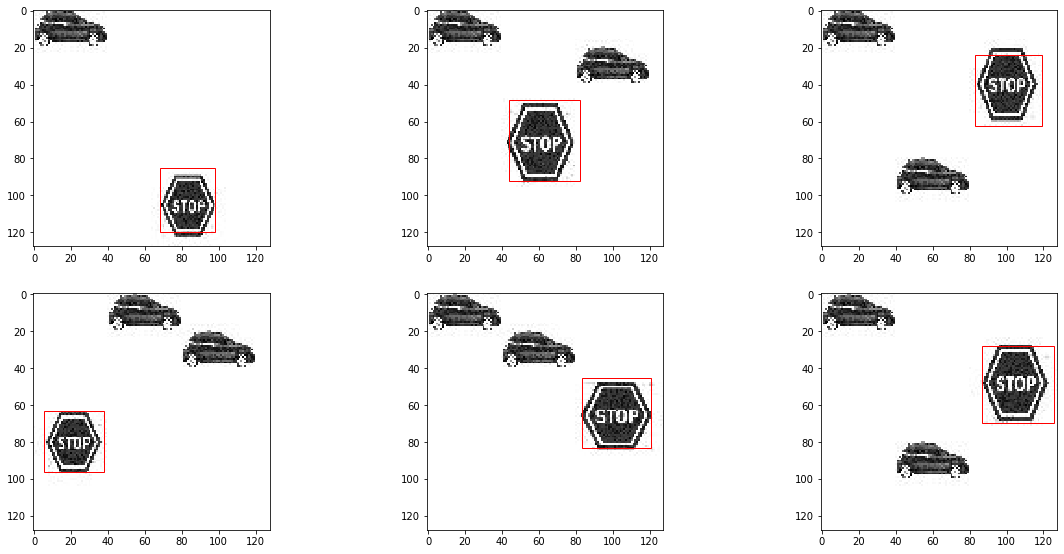

In [ ]:
### Loading new test data
import matplotlib
from matplotlib import pyplot as plt
import glob
import base64
from PIL import Image
from skimage import io, color
import numpy as np
img_size = 128 
idx=1
img_number = list()
img_store = list()
im_rows = 128
im_cols = 128
im_shape = (im_rows, im_cols, 1)
for test_img in sorted(glob.glob('dataset_object/test_data/*.jpg')):
  img = Image.open(test_img) # RGB mode with three channel
  img = img.convert("P")  # convert into one channel
  img = img.resize((img_size, img_size)) # resize
  # convert into numpy array
  img_data = np.asarray(img).copy()
  img_data[img_data>=np.quantile(img_data,0.8)] = 255 # set background to white
  ### normalize test data using mean & std from training
  img_data_norm = (img_data - train_mean) / train_std
  img_store.append(img_data_norm)
  img_number.append(img_data_norm)
 
my_image = np.array(img_number)
img_data_reshape = my_image.reshape(my_image.shape[0], *im_shape)
plt.figure(figsize=(20, 20))
pred_y = model_loaded.predict(img_data_reshape)
for images in img_store:
  pred_bboxes = pred_y[idx-1] * img_size
  pred_bboxes = pred_bboxes.reshape(len(pred_bboxes), 1, -1)
  pred_bboxes.shape
  plt.subplot(4, 3, idx)
  idx +=1
  plt.imshow(images, cmap='gray', interpolation='nearest')
  plt.gca().add_patch(matplotlib.patches.Rectangle((pred_bboxes[0], pred_bboxes[1]), pred_bboxes[2], pred_bboxes[3], ec='r', fc='none'))